In [68]:
#from main import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle

CALIBRATION__JPG = "calibration1.jpg"
TRANSFORMATION__JPG = "test5.jpg"
FOLDER_TEST_INPUT = "test_images/"
FOLDER_OUTPUT = "output_images/"
FOLDER_CAMERA_CAL = "camera_cal/"
INPUT_VIDEO = "project_video.mp4"
# INPUT_VIDEO = "challenge_video.mp4"
# INPUT_VIDEO = "harder_challenge_video.mp4"

TEST_RUN = True
SOBEL_KERNEL = 3

%matplotlib inline


In [17]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
def get_camera_cali_params():
    nx, ny = 6, 9
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(FOLDER_CAMERA_CAL + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        # if not ret:
        #     nx, ny = 9,5
        #     objp = np.zeros((nx * ny, 3), np.float32)
        #     objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        #     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if not ret:
        #     nx, ny = 8,6
        #     objp = np.zeros((nx * ny, 3), np.float32)
        #     objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        #     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            if TEST_RUN:
                # Draw and display the corners
                img_with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                save_image_as_png(img_with_corners, "1_corners_detected_", fname.split('\\')[-1].split('.')[0])
        else:
            print("No corners found in image: " + fname)
    return objpoints, imgpoints


# save image as png to OUTPUT_FOLDER
def save_image_as_png(img, prefix, filename):
    cv2.imwrite(FOLDER_OUTPUT + prefix + filename + ".png", img)


# get coefficients from camera calibration
def calibrate_camera(folder, img, obj_p, img_p):
    filename = img.split('.')[0]
    img = cv2.imread(folder + img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_p, img_p, gray.shape[0:2], None, None)

    if TEST_RUN:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        save_image_as_png(dst, "2_undistorted_", filename)

    return mtx, dist


In [18]:
obj_points, img_points = get_camera_cali_params()


In [19]:
cali_mtx, cali_dist = calibrate_camera(FOLDER_CAMERA_CAL, CALIBRATION__JPG, obj_points, img_points)


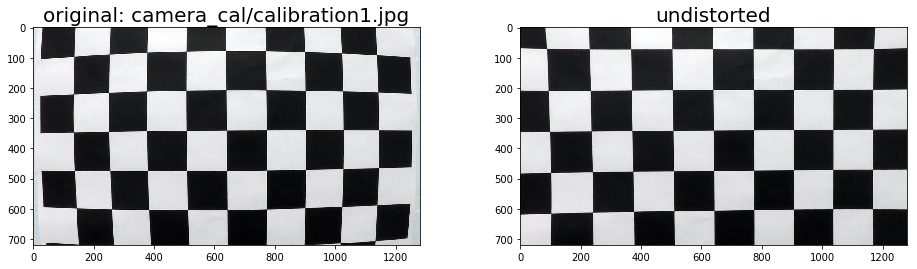

In [63]:
calibration_file = FOLDER_CAMERA_CAL + CALIBRATION__JPG
dst = cv2.undistort(cv2.imread(calibration_file), cali_mtx, cali_dist, None, cali_mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.imshow(cv2.imread(calibration_file))
ax1.set_title('original: ' + calibration_file, fontsize=20)
ax2.imshow(dst)
ax2.set_title('undistorted', fontsize=20)


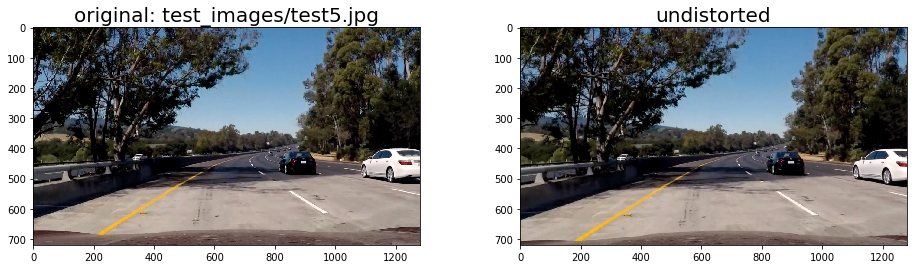

In [164]:
transformation_file = FOLDER_TEST_INPUT + TRANSFORMATION__JPG
transformation_image = cv2.imread(transformation_file)
transformation_image = cv2.cvtColor(transformation_image, cv2.COLOR_BGR2RGB)
distorted_image = cv2.undistort(transformation_image, cali_mtx, cali_dist, None, cali_mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.imshow(example)
ax1.set_title('original: ' + transformation_file, fontsize=20)
ax2.imshow(distorted_image)
ax2.set_title('undistorted', fontsize=20)


In [ ]:


# from Udacity
def s_channel_and_gradient_threshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 70
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary


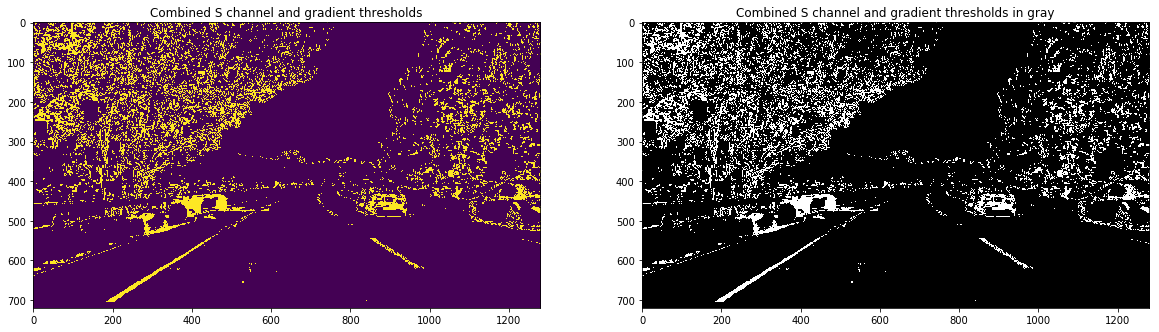

In [165]:
combined_binary = s_channel_and_gradient_threshold(distorted_image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Combined S channel and gradient thresholds')
ax1.imshow(combined_binary)

ax2.set_title('Combined S channel and gradient thresholds in gray')
ax2.imshow(combined_binary, cmap='gray')

In [155]:
# from Udacity
def unwarp(img, src, dst):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [162]:
offset = 450
h, w = combined_binary.shape[:2]
# define source and destination points for transform
src = np.float32([(575, 464),
                  (707, 464), 
                  (258, 682), 
                  (1049, 682)])
dst = np.float32([(offset, 0),
                  (w-offset, 0),
                  (offset, h),
                  (w-offset, h)])

warped_binary, M, Minv = unwarp(combined_binary, src, dst)

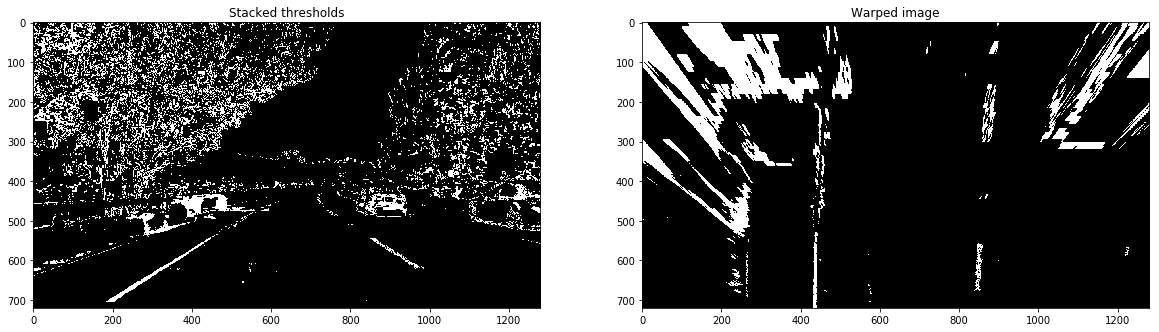

In [163]:
# Plotting warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Stacked thresholds')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Warped image')
ax2.imshow(warped_binary, cmap='gray')


In [109]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


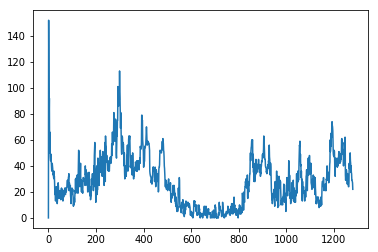

In [110]:

# Create histogram of image binary activations
histogram = hist(combined_binary)

# Visualize the resulting histogram
plt.plot(histogram)
